In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [2]:
# 1. Setup: Define directories
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

In [13]:
# 2. Data Preparation (Load CSV instead of mock data)
data_censored = pd.read_csv("data_censored.csv")
data_censored.drop(columns=["Unnamed: 0"], inplace=True)  # Drop unnecessary index column
print(data_censored.head())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  


In [15]:
# Per-Protocol (PP) and Intention-to-Treat (ITT) trial objects
trial_pp = data_censored.copy()
trial_itt = data_censored.copy()

In [5]:
# 3. Weight models and censoring
# Censoring due to treatment switching
logit_switch = LogisticRegression()
logit_switch.fit(trial_pp[["age", "x1", "x3"]], trial_pp["treatment"])
trial_pp["switch_weight"] = logit_switch.predict_proba(trial_pp[["age", "x1", "x3"]])[:, 1]

In [6]:
# Other informative censoring
logit_censor = LogisticRegression()
logit_censor.fit(trial_pp[["x2", "x1"]], trial_pp["censored"])
trial_pp["censor_weight"] = logit_censor.predict_proba(trial_pp[["x2", "x1"]])[:, 1]

In [7]:
# Apply same to ITT
logit_censor_itt = LogisticRegression()
logit_censor_itt.fit(trial_itt[["x2", "x1"]], trial_itt["censored"])
trial_itt["censor_weight"] = logit_censor_itt.predict_proba(trial_itt[["x2", "x1"]])[:, 1]

In [8]:
# 4. Outcome Model using Kaplan-Meier Estimator
kmf = KaplanMeierFitter()
kmf.fit(durations=trial_itt["period"], event_observed=trial_itt["outcome"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 725 total observations, 714 right-censored observations>

In [9]:
# 5. Survival Predictions
survival_times = np.arange(0, 11)
survival_probs = kmf.predict(survival_times)

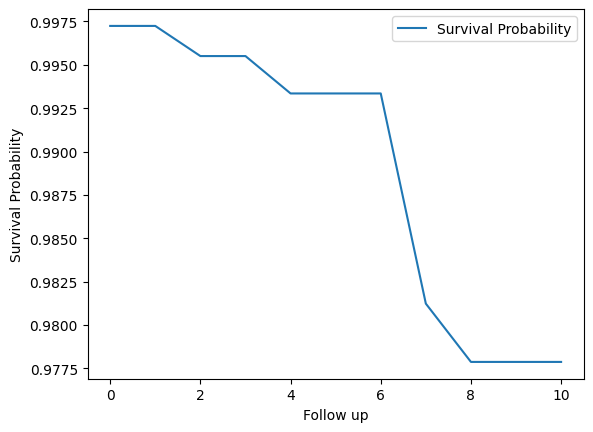

In [12]:
# 6. Plot Survival Difference
plt.plot(survival_times, survival_probs, label='Survival Probability')
plt.xlabel("Follow up")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()